# Quantum Blur Height Map Frame Generator
(Generates frames for a Quantum Blur heightmap animation)

## Import the Necessary Librarys

In [1]:
import numpy as np
import math

from PIL import Image

import quantumblur as qb
from qiskit import QuantumCircuit

## Choose a Backend

### IBM Quantum Machine (Normal users are limited to 5 Qubits & moderately long queue times)

In [2]:
from qiskit import IBMQ, transpile

provider = IBMQ.load_account()
backend = provider.backend.ibmq_manila

### Simulation on Device (Reccomended for most users as it's faster)

In [2]:
from qiskit import execute, Aer

## Create a random seed

### Random Seed Quantum Circuit

Edit this to change the QuantumBlur seed

In [9]:
height_map_size = 5 # Size of one side of the height map (ex. 16 = 16x16)
random_points = 0.25 # As a percentage

size = height_map_size if height_map_size > 256 else 256

(This is essentially a random number generator, just using a quantum circuit to stick with the theme)

In [10]:
height_map_area = height_map_size ** 2
num_qubits = math.log(height_map_area, 2)
num_points = height_map_area * random_points

# Create a quantum circuit with enough qubits to represent the height map
random_circuit = QuantumCircuit(int(num_qubits))

# Add an H gate to every qubit in the circuit so it has an equal chance to be in the |1> state
for i in range(random_circuit.num_qubits):
        random_circuit.h(i)

random_circuit.measure_all()

### Run Circuit

Through IBM Quantum System

In [12]:
transpiled = transpile(random_circuit, backend=backend)

job = backend.run(transpiled, shots=int(num_points))
retrieved_job = backend.retrieve_job(job.job_id())

On Computer

In [17]:
job = execute(random_circuit, Aer.get_backend('qasm_simulator'), shots=num_points)

### Display Random Seed

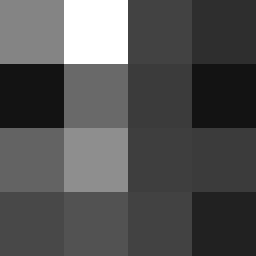

In [26]:
counts = job.result().get_counts()
height_map = qb.probs2height(counts)

qb.height2image(height_map).resize((size, size), 4)

### Alternative Method

Random Number Through IBM Quantum 1 Qubit (Less accurate and heights can only be 1 or 0; however, can seed a very large height map while still useing an actual quantum computer)

In [7]:
height_map_area = height_map_size ** 2
num_points = height_map_area * random_points

# Create a quantum circuit with enough qubits to represent the height map
random_circuit = QuantumCircuit(1)

# Add an rx gate to the qubit so to reqplicate the probability distribution of the multiple qubit measurement
probability = (1 - (1 / (height_map_area / num_points)))
rotation = math.pi / (2 * math.acos(math.sqrt(probability)))
random_circuit.rx(rotation, 0)
random_circuit.measure_all()

one_qubit_backend = provider.backend.ibmq_armonk
transpiled = transpile(random_circuit, backend=one_qubit_backend)

job = one_qubit_backend.run(transpiled, shots=height_map_area, memory=True)
retrieved_job = one_qubit_backend.retrieve_job(job.job_id())

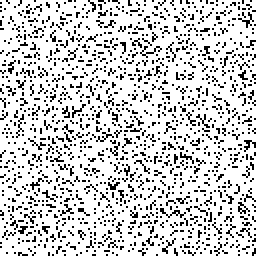

In [12]:
mem = job.result().get_memory()
height_map = np.reshape(np.array(list(map(np.uint8, mem))), (height_map_size, height_map_size))
height_map = height_map * 255

img = Image.fromarray(height_map).resize((256,256), 4)

def to_height_map(img):
    height_map = {}
    for rowNum in range(len(img)):
        row = img[rowNum]
        for pixelNum in range(len(row)):
            pixel = (pixelNum, rowNum)
            height_map[pixel] = img[rowNum][pixelNum]
    return height_map

height_map = to_height_map(height_map)

img

## Create Quantum Blur

In [21]:
xi = 1.5
blurred_circuit = qb.blur_height(height_map, xi)

### Run Circuit

Useing IBMQ Backend (can't have an image more than 5x5 with a 5 qubit machine)

In [22]:
quality = 1 # Enter a number from 0 to 1

blurred_circuit.measure_all()

transpiled = transpile(blurred_circuit, backend=backend)
job = backend.run(transpiled, shots=height_map_area * 16 * quality)
retrieved_job = backend.retrieve_job(job.job_id())

In [24]:
counts = job.result().get_counts()
blurred_height_map = qb.probs2height(counts)

Using Aer Backend (can run more than a 5x5 but quickly becomes inefficient becasue of the sheer amount of shots required to generate a quality blurred height map)

In [ ]:
quality = 1 # Enter a number from 0 to 1

blurred_circuit.measure_all()

job = execute(blurred_circuit, Aer.get_backend('qasm_simulator'), shots=height_map_area * 16 * quality)

counts = job.result().get_counts()
blurred_height_map = qb.probs2height(counts)

Useing the circuit to calculate the best properties, due to the limits in quantum computeing its currenlty the best option for any image over 32x32; this, however, will produce the same result every time and is not random as the circuit is not being simulated and is instead being derived into an image through the caclulated probabilities.

In [ ]:
blurred_height_map = qb.circuit2height(blurred_circuit)

## Display Blurred Image

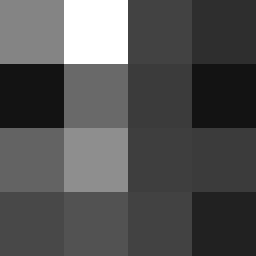

In [25]:
qb.height2image(blurred_height_map).resize((256,256), 4)

## Create Quantum Blur Animation

In [18]:
step = 0.05 # Amount of blur to iterate by each frame, reccomended around 0.05 for relatively smooth animation
ending_blur = 5 # At what xi value the animation should end

In [19]:
for i in range(int(ending_blur / step)):
    xi = step * i
    blurred_circuit = qb.blur_height(height_map, xi)
    blurred_height_map = qb.circuit2height(blurred_circuit)
    frame = qb.height2image(blurred_height_map).resize((size, size), 4)
    frame.save(f'frames/frame{i}.png')